<a href="https://colab.research.google.com/github/kashishthakur26/Tensorflow-learning/blob/main/transfer_learning_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Transfer learning with tensorflow part-1 : Feature extraction

### Downloading a data

In [1]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close

--2023-06-01 04:21:42--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 172.253.118.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  16.7MB/s    in 10s     

2023-06-01 04:21:54 (15.6 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



<bound method ZipFile.close of <zipfile.ZipFile filename='10_food_classes_10_percent.zip' mode='r'>>

In [2]:
import os
for dirpath , dirnames , filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

##Preparing data for building the model

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images: ")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMG_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing images: ")
test_data = test_datagen.flow_from_directory(test_dir,
                                                          target_size=IMG_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

Training images: 
Found 750 images belonging to 10 classes.
Testing images: 
Found 2500 images belonging to 10 classes.


## Setting up callbacks 
callbacks are extra functionality you can add tonyour models to be performed
during or after training. Some of the most popular callbacks:

* Tracking experiments witht the tensorboard callback.
* Model checkpoint with the ModelCheckpoint callbacks.
* Stopping a model from training with earlystopping callbakcs.

In [22]:
import datetime

def create_tensorboard_callback(dir_name , experiment_name):
  log_dir = dir_name +"/"+ experiment_name +"/"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")

  return tensorboard_callback


## Creating model using tensorflow Hub

In [27]:
# Lets compare following two models

resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"


efficient_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [7]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [11]:
def create_model(model_url , num_classes=10):

  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="feature_extraction_layer",
                                           input_shape=IMG_SHAPE+(3,))
  
  model = tf.keras.Sequential([
      feature_extractor_layer , 
      layers.Dense(num_classes ,activation="softmax", name="output_layer")
  ])

  return model

In [28]:
## Creating and testing ResNet Tensorflow Hub Feature Exraction model

resnet_model = create_model(resnet_url,
                            num_classes = train_data_10_percent.num_classes)

In [30]:
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [13]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [31]:
history_resnet = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data = test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20230601-045433
Epoch 1/5
24/24 [==============================] - 24s 856ms/step - loss: 1.8081 - accuracy: 0.3987 - val_loss: 1.1353 - val_accuracy: 0.6460
Epoch 2/5
24/24 [==============================] - 19s 834ms/step - loss: 0.8796 - accuracy: 0.7440 - val_loss: 0.8997 - val_accuracy: 0.7112
Epoch 3/5
24/24 [==============================] - 18s 773ms/step - loss: 0.5881 - accuracy: 0.8467 - val_loss: 0.7673 - val_accuracy: 0.7488
Epoch 4/5
24/24 [==============================] - 19s 828ms/step - loss: 0.4704 - accuracy: 0.8813 - val_loss: 0.6962 - val_accuracy: 0.7780
Epoch 5/5
24/24 [==============================] - 18s 781ms/step - loss: 0.3723 - accuracy: 0.9120 - val_loss: 0.6708 - val_accuracy: 0.7864


In [33]:
import matplotlib.pyplot as plt
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

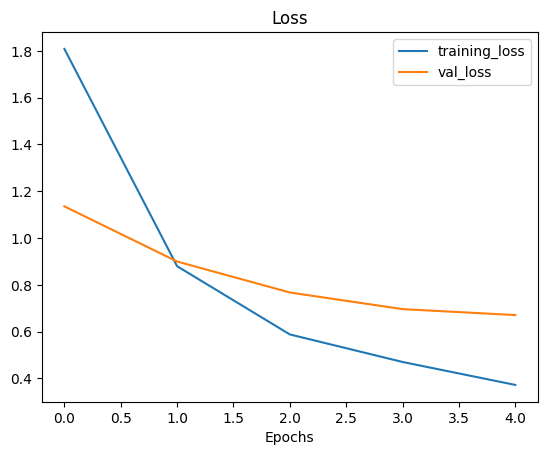

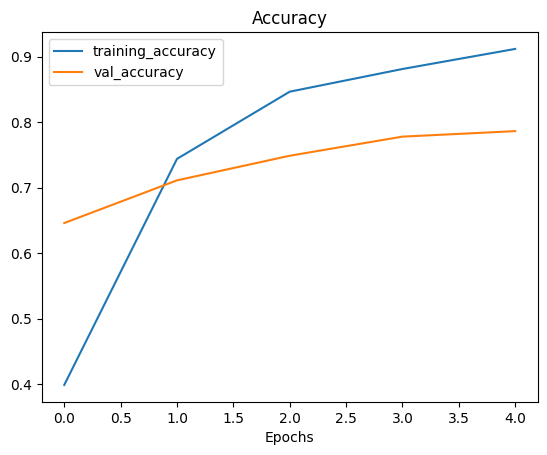

In [34]:
plot_loss_curves(history_resnet)

In [32]:
# Create EfficientNetB0 feature extractor model
efficientnet_model  = create_model(model_url = efficient_url,
                                   num_classes = train_data_10_percent.num_classes)

efficientnet_model.compile(loss="categorical_crossentropy",
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["accuracy"])

efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch= len(train_data_10_percent),
                                              validation_data = test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="efficientnetb0")])


Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20230601-051041
Epoch 1/5
24/24 [==============================] - 32s 912ms/step - loss: 1.8444 - accuracy: 0.4400 - val_loss: 1.2985 - val_accuracy: 0.7288
Epoch 2/5
24/24 [==============================] - 25s 1s/step - loss: 1.0677 - accuracy: 0.7547 - val_loss: 0.8714 - val_accuracy: 0.8116
Epoch 3/5
24/24 [==============================] - 19s 799ms/step - loss: 0.7677 - accuracy: 0.8227 - val_loss: 0.7014 - val_accuracy: 0.8408
Epoch 4/5
24/24 [==============================] - 18s 776ms/step - loss: 0.6151 - accuracy: 0.8560 - val_loss: 0.6134 - val_accuracy: 0.8548
Epoch 5/5
24/24 [==============================] - 17s 749ms/step - loss: 0.5207 - accuracy: 0.8840 - val_loss: 0.5589 - val_accuracy: 0.8596


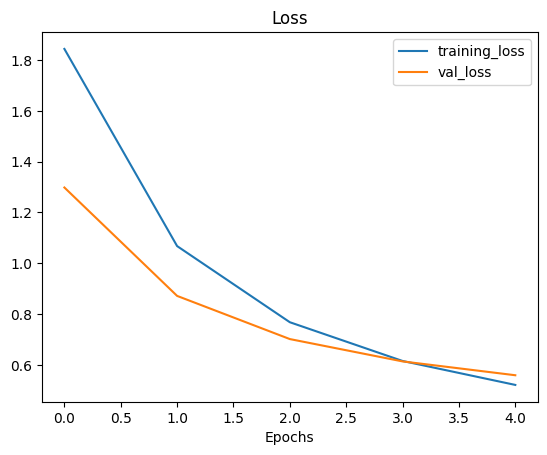

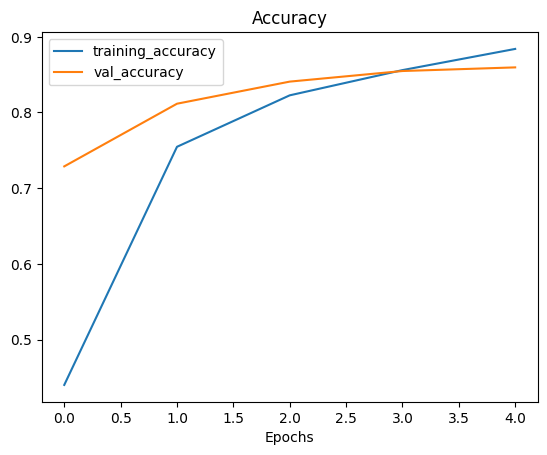

In [36]:
plot_loss_curves(efficientnet_history)

## Comapring resnet and efficientnet model using tensorboard

In [38]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot

2023-06-01 05:44:21.287088: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   QPFQ-GDKC

QPFQ-GDKC


New experiment created. View your TensorBoard at: https://tensorboar